# FOLLOW UP THESIS ANALYSES

- Understand "WHALES" 
    - BET CUTOFFS BASED ON SIZE (OVERALL BETS) 
    - QUANTILES
- CONDITIONAL N-GRAMS
    - W/L conditions
    - 2-GRAMS, 3-GRAMS
    - SIGNAL (-, 0, +) 
    - kurtosis 
- AVERAGE TIME SPENT BETTING
    - SINGLE DAY?
    - MULTIPLE? 
- RISK SEGMENTATION 
    - CLUSTERING? 
    

In [1]:
import pandas as pd
import os 
import matplotlib.pyplot as plt

from sklearn import mixture, cluster

from scipy.stats import kurtosis 
from scipy import stats

import numpy as np

from itertools import product

## Data Organization

In [2]:
basepath = '/Users/jmeng/Desktop/dart projects/Research/thesis/contract_subset'

listing = os.listdir(basepath)

files = [c for c in listing if '.csv' in c]

os.chdir(basepath)

total_contracts = list(map(lambda x: pd.read_csv(x, sep = ';').sort_values('Date'), files))

for index, contract in enumerate(total_contracts): 
    contract['contract_type'] = files[index].split('.')[0]

In [3]:
all_user_data = pd.concat(total_contracts, ignore_index = True)


In [4]:
# c2_proper_data = os.listdir('/Users/jmeng/Desktop/dart projects/Research/thesis/date_subsetted/data/raw_data_2')
# os.chdir('/Users/jmeng/Desktop/dart projects/Research/thesis/date_subsetted/data/raw_data_2')

# c2_proper_data_collected = list(map(lambda x: pd.read_csv(x, sep = ';').sort_values('Date'), c2_proper_data))

# c2_data = pd.concat(c2_proper_data_collected).sort_values('Date')

# c2_data['contract_type'] = 'c2'

# c2_data = c2_data[all_user_data.columns]


In [5]:

all_user_data['Probability'] = (all_user_data['Chance'] - 1)/100.0



## understanding whales

In [6]:

import matplotlib.pyplot as plt

pd_final = all_user_data[['Player', 'contract_type', 'Bet']].groupby(['Player', 'contract_type']).sum()

pd_final

Bet
Player                 contract_type         
Against the odds #2774 c1               0.100
                       c2               0.400
Against the odds #2780 c1               4.050
Against the odds #2794 c1               0.960
Against the odds #2905 c2               1.100
Against the odds #2932 c2               0.400
Against the odds #3038 c3               0.500
Against the odds #3101 c3               0.580
Against the odds #3122 c3               0.840
Against the odds #3187 c3               0.350
Against the odds #3204 c3               4.000
Against the odds #3267 c3               0.837
Against the odds #3334 c3               0.900
Against the odds #3401 c3               3.500
                       c4               0.200
Against the odds #3426 c3               2.900
Against the odds #3492 c3               0.460
Against the odds #3526 c3               1.400
Against the odds #3619 c3               1.750
Against the odds #3795 c3             149.900
Against the odds #3826 c3               1.280
Against the odds #3875 c3               0.480
Against the odds #3897 c3               0.400
Against the odds #4049 c3               0.700
Against the odds #4142 c3               0.300
Against the odds #4153 c3               0.300
Against the odds #4155 c3               0.300
Against the odds #4203 c3              19.000
Against the odds #4439 c3               0.555
Against the odds #4660 c3               0.300
...                                       ...
Professional #5405     c4               6.876
Professional #5433     c4              13.800
Professional #5449     c4              29.350
Professional #5454     c4              25.340
Professional #5465     c4               8.560
Professional #5484     c4              31.700
Professional #5485     c4              14.500
Professional #5519     c4             263.000
Professional #5520     c4              89.110
Professional #5540     c4             412.448
Professional #5547     c4               7.120
Professional #5558     c4             153.500
Professional #5562     c4             109.390
Professional #5572     c4              29.440
Professional #5578     c4             112.585
Professional #5580     c4             359.919
Professional #5607     c4              68.249
Professional #5612     c4              11.130
Professional #5616     c4              16.500
Professional #5619     c4             315.200
Professional #5639     c4              55.226
Professional #5655     c4             196.900
Professional #5677     c4              16.700
Professional #5691     c4              26.140
Professional #5698     c4              29.130
Professional #5753     c4               6.897
Professional #5758     c4              13.966
Professional #5778     c4              14.570
Professional #5796     c4               9.040
microetheroll.com#5506 c4               0.100

[3001 rows x 1 columns]

## ngrams

- discretized signal (0/1/-1) 

In [7]:
base_path = './newplots'

os.chdir('/Users/Jmeng/Desktop')
def ngrams(sequence, n, pad_left=False, pad_right=False, pad_symbol=None):

    if pad_left:
        sequence = chain((pad_symbol,) * (n-1), sequence)
    if pad_right:
        sequence = chain(sequence, (pad_symbol,) * (n-1))
    sequence = list(sequence)

    count = max(0, len(sequence) - n + 1)
    return [[float(format(i, '.4f')) for i in sequence[i:i+n]] for i in range(count)]

def workflow(df): 
    df = df.copy(deep = True)
#     df = df[df.contract_type == contract]
    df.loc[df['Paid_ETH'] == '-', 'Paid_ETH'] = -1*df['Bet']

    new = df["Paid_ETH"].str.split(" ", n = 1, expand = True) 

    df['Payout'] = pd.to_numeric(new[0])
    
    df['Payout'] = pd.to_numeric(df.Payout.combine_first(df.Paid_ETH))
    
    for col_type in ['Bet', 'Probability']:
        df['Next {}'.format(col_type)] = (df.sort_values(by=['Date'], ascending=True)
                       .groupby(['Player', 'contract_type'])[col_type].shift(-1))  
        
    
    df['Cumulative Profit'] = (df.sort_values(by=['Date'], ascending=True)
                        .groupby(['Player', 'contract_type'])['Payout'].agg(np.cumsum))

    return df
    
def top_grams(df, col_type):
    two_grams = df.groupby([col_type, 'Next {}'.format(col_type)]).size().reset_index()
    
    two_grams.columns = [lower(col_type), 'next_{}'.format(col_type), 'instances']
    
    two_grams = two_grams.sort_values(by = ['instances'], ascending = False)
    
    return two_grams
    
def signal_analysis(data, result = None):
    data  = workflow(data)
    if result is not None:
        data = data[data['Result'] == result]
    
    for col_type in ['Bet', 'Probability']:
        col_name = '{} Signal'.format(col_type)
        col_name_pct = '{} Signal Percentage'.format(col_type)

        encoded_col_name = 'Encoded {} Signal'.format(col_type)
        
        encoded_col_name_pct = 'Encoded {} Signal Percentage'.format(col_type)


        data[col_name] = data['Next {}'.format(col_type)] - data[col_type]
        
        data[col_name_pct] = (data['Next {}'.format(col_type)] - data[col_type])/data[col_type]

        data[encoded_col_name] = '0'
        data.loc[data[col_name] < 0 , encoded_col_name] = '-'
        data.loc[data[col_name] > 0 , encoded_col_name] = '+'

        data[encoded_col_name_pct] = '0'
        data.loc[data[col_name_pct] < 0 , encoded_col_name_pct] = '-'
        data.loc[data[col_name_pct] > 0 , encoded_col_name_pct] = '+'

    return data

def get_distribution(df, col_name, write = True):
    
    df = df.copy(deep = True)
    
    plt.clf()
    
    fig, ax = plt.subplots(2,2, figsize = (10,10), dpi = 100)

    ax = ax.flatten()

    for axs, contract in zip(ax,['c{}'.format(i) for i in range(1, 5)]):
        contract_subset = df[df['contract_type'] == contract]

        bool_series = pd.notnull(contract_subset[col_name]) 
        
        axs.hist(contract_subset[bool_series][col_name], facecolor='blue', alpha=0.5, edgecolor='black', linewidth=1)
        axs.set_yscale('log', nonposy='clip')
        
        axs.set_xlabel(col_name)
        axs.set_ylabel('log(Probability)')

        axs.grid()
        axs.set_title('{} Distribution for Contract {}'.format(col_name, contract.replace('c', '')))
    
    if write is True: 
        plt.savefig('{}/{}.png'.format(base_path, 'Distribution_{}'.format(col_name)))
    plt.close()

    return fig

def plot_QQ(df, col_name, write = True): 

    plt.clf()
    fig, ax = plt.subplots(2,2, figsize = (10,10), dpi = 100)

    ax = ax.flatten()

    for axs, contract in zip(ax,['c{}'.format(i) for i in range(1, 5)]):
        contract_subset = df[df['contract_type'] == contract]

        bool_series = pd.notnull(contract_subset[col_name]) 

        res = stats.probplot(contract_subset[bool_series][col_name], dist=stats.norm, sparams=(2.5,), plot=axs)

        axs.grid()
        title_name = 'Q-Q of {}, Contract {}'.format(col_name, contract.replace('c', ''))
        axs.set_title(title_name)
    if write is True: 
        plt.savefig('{}/{}.png'.format(base_path, 'Q_Q_{}'.format(col_name)))
    plt.close()
    return fig


def get_summ_stats(df, axis_type):
    return {'mean': df[axis_type].mean(), 
            'variance': df[axis_type].var(),
            'skewness': df[axis_type].skew(), 
            'kurtosis': df[axis_type].kurtosis()}

In [8]:
post_etl = signal_analysis(all_user_data)
post_etl.groupby(['contract_type', 'Result']).agg({'Bet Signal': ['mean', 'var', 'skew']})

Bet Signal                      
                               mean        var       skew
contract_type Result                                     
c1            lost         0.500086  15.756283   9.337494
              unresolved   0.000000   0.000000   0.000000
              won         -0.236939  15.069487 -11.003162
c2            lost         0.833769  31.944120   7.014670
              won         -0.379956  22.667950  -9.296448
c3            lost         0.392854  10.284549   5.940605
              unresolved  -0.061431   4.133437  -2.233493
              won         -0.253532  11.253303  -6.343695
c4            lost         0.153857   2.975718   3.096327
              pending      0.500000        NaN        NaN
              unresolved  -0.427423  18.608581 -13.245059
              won         -0.086056   4.231205  -3.335088

In [37]:
post_etl['Encoded Probability Signal Percentage'].value_counts()

0    99260
-    44256
+    42325
Name: Encoded Probability Signal Percentage, dtype: int64

In [9]:
post_etl

,Date,Player,Bet,Chance,Result,Paid_ETH,Paid_USD,ID,contract_type,Probability,...,Next Probability,Cumulative Profit,Bet Signal,Bet Signal Percentage,Encoded Bet Signal,Encoded Bet Signal Percentage,Probability Signal,Probability Signal Percentage,Encoded Probability Signal,Encoded Probability Signal Percentage
0,2017-05-23 11:50:45,Intermediate #2942,0.10,99,won,0.101 Eth,$ 77.79,132826,c3,0.98,...,0.01,0.101,0.00,0.000000,0,0,-0.97,-0.989796,-,-
1,2017-05-23 11:53:27,Intermediate #2942,0.10,2,lost,-0.1,-,132825,c3,0.01,...,0.50,0.001,0.00,0.000000,0,0,0.49,49.000000,+,+
2,2017-05-23 12:01:34,Intermediate #2942,0.10,51,won,0.198 Eth,$ 152.46,132824,c3,0.50,...,0.01,0.199,0.00,0.000000,0,0,-0.49,-0.980000,-,-
3,2017-05-23 12:20:12,Intermediate #2943,0.10,31,won,0.330 Eth,$ 254.10,132823,c3,0.30,...,0.38,0.330,0.10,1.000000,+,+,0.08,0.266667,+,+
4,2017-05-23 12:22:56,Intermediate #2942,0.10,2,lost,-0.1,-,132822,c3,0.01,...,0.98,0.099,0.00,0.000000,0,0,0.97,97.000000,+,+
5,2017-05-23 12:35:24,Intermediate #2943,0.20,39,lost,-0.2,-,132821,c3,0.38,...,0.71,0.130,-0.10,-0.500000,-,-,0.33,0.868421,+,+
6,2017-05-23 13:16:03,Professional #2944,0.10,81,won,0.124 Eth,$ 95.29,132820,c3,0.80,...,0.50,0.124,0.40,4.000000,+,+,-0.30,-0.375000,-,-
7,2017-05-23 13:20:11,Professional #2945,0.10,51,lost,-0.1,-,132819,c3,0.50,...,0.50,-0.100,0.00,0.000000,0,0,0.00,0.000000,0,0
8,2017-05-23 13:35:02,Newbie #2946,0.10,51,won,0.198 Eth,$ 152.46,132818,c3,0.50,...,NaN,0.198,NaN,NaN,0,0,NaN,NaN,0,0
9,2017-05-23 13:54:52,Intermediate #2947,0.10,51,lost,-0.1,-,132817,c3,0.50,...,0.90,-0.100,0.00,0.000000,0,0,0.40,0.800000,+,+


In [10]:
post_etl.groupby(['contract_type']).apply(pd.DataFrame.kurt)


,Bet,Chance,ID,Probability,Payout,Next Bet,Next Probability,Cumulative Profit,Bet Signal,Bet Signal Percentage,Probability Signal,Probability Signal Percentage
contract_type,,,,,,,,,,,,
c1,77.996440,-0.353502,-1.2,-0.353502,73.230452,74.464423,-0.371276,29.892439,213.661672,271.630237,6.677930,164.032868
c2,143.472018,-0.606573,-1.2,-0.606573,116.040429,139.275250,-0.607628,6.865279,138.463358,305.104864,4.755021,290.599101
c3,118.485915,-0.617207,-1.2,-0.617207,77.137997,117.699508,-0.623831,25.752442,224.058510,3271.408829,7.122108,1223.213609
c4,208.941745,-0.322855,-1.2,-0.322855,125.197637,207.774204,-0.332162,19.279385,392.423512,809.560684,3.924821,251.551589


In [60]:
post_etl.groupby(['contract_type', 'Result']).apply(pd.DataFrame.kurt)


Bet    Chance        ID  Probability  \
contract_type Result                                                    
c1            lost        385.584803 -0.930191 -0.864397    -0.930191   
              unresolved         NaN       NaN       NaN          NaN   
              won          52.125493  0.349432 -1.340673     0.349432   
c2            lost        284.513794 -0.483279 -1.000036    -0.483279   
              won         106.027531 -0.403406 -1.184493    -0.403406   
c3            lost        160.639667 -0.686614 -1.045872    -0.686614   
              unresolved   44.966355 -0.611453 -1.001536    -0.611453   
              won          96.146723 -0.414760 -1.294574    -0.414760   
c4            lost        108.813130 -0.953007 -1.219431    -0.953007   
              pending            NaN       NaN       NaN          NaN   
              unresolved  160.886933 -0.461265 -1.436143    -0.461265   
              won         188.726991  0.280478 -1.151486     0.280478   

                              Payout    Next Bet  Next Probability  \
contract_type Result                                                 
c1            lost        385.584803  157.833274         -0.974593   
              unresolved         NaN         NaN               NaN   
              won          50.116671   57.657101          0.486981   
c2            lost        284.513794  113.080194         -0.413442   
              won          90.542153  144.135532         -0.203855   
c3            lost        160.639667  128.452092         -0.554254   
              unresolved   44.966355   48.863315         -0.660604   
              won          63.671094  112.878472         -0.106266   
c4            lost        108.813130  117.517414         -0.679432   
              pending            NaN         NaN               NaN   
              unresolved  160.886933   32.035149         -0.332130   
              won         113.167914  227.000389          0.794811   

                          Cumulative Profit  Bet Signal  \
contract_type Result                                      
c1            lost                40.331747  166.250980   
              unresolved                NaN         NaN   
              won                 26.135904  239.893314   
c2            lost                 8.123992   94.289493   
              won                  6.264887  175.022232   
c3            lost                54.368280  201.415675   
              unresolved          38.251987   49.068821   
              won                 18.015730  238.124884   
c4            lost                36.510688  187.581550   
              pending                   NaN         NaN   
              unresolved          18.244555  197.932591   
              won                 14.154698  434.364537   

                          Bet Signal Percentage  Probability Signal  \
contract_type Result                                                  
c1            lost                   119.894211            6.541141   
              unresolved                    NaN                 NaN   
              won                    391.116112            6.261950   
c2            lost                   134.655744            3.683125   
              won                    143.566267            5.258727   
c3            lost                  1859.956863            5.933193   
              unresolved              50.998856            7.927944   
              won                   5387.912651            7.680734   
c4            lost                   322.011884            2.214363   
              pending                       NaN                 NaN   
              unresolved             268.738879            3.833257   
              won                   1070.231543            5.280608   

                          Probability Signal Percentage  
contract_type Result                                     
c1            lost                            77.386769  
              unresolved         

In [10]:
%%capture
post_etl = signal_analysis(all_user_data)

plot_QQ(post_etl, 'Bet Signal')
plot_QQ(post_etl, 'Probability Signal')

get_distribution(post_etl, 'Bet Signal')
get_distribution(post_etl, 'Probability Signal')


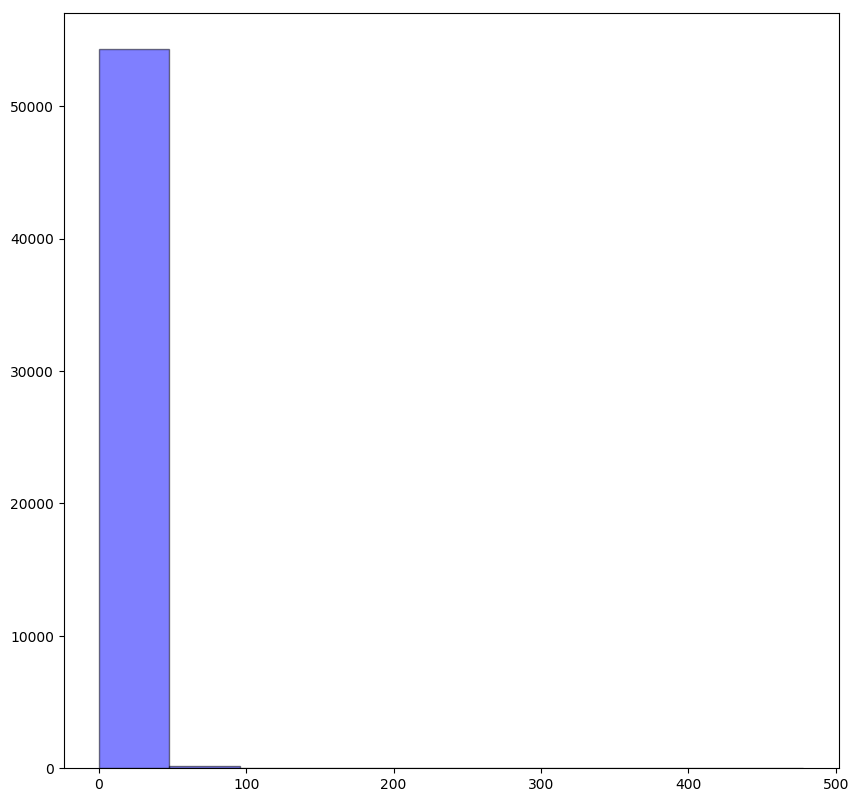

In [54]:
plt.clf()

fig, ax = plt.subplots(1,1, figsize = (10,10), dpi = 100)


ax.hist(post_etl[post_etl['Bet Signal Percentage'] > 0]['Bet Signal Percentage'], facecolor='blue', alpha=0.5, edgecolor='black', linewidth=1)
plt.show()

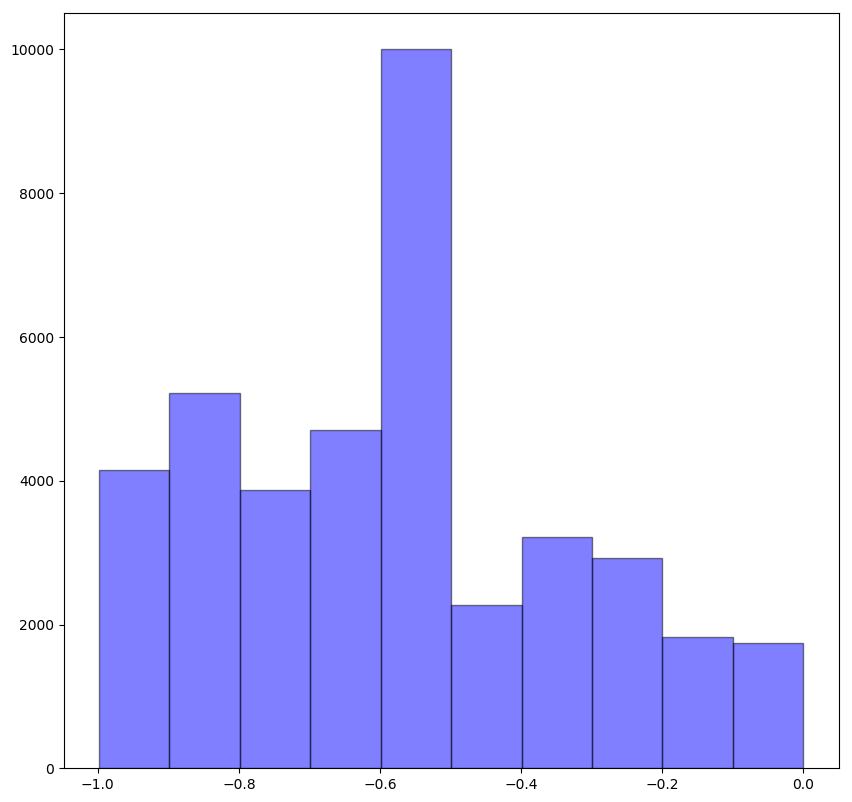

In [50]:
plt.clf()
fig, ax = plt.subplots(1,1, figsize = (10,10), dpi = 100)

ax.hist(post_etl[post_etl['Bet Signal Percentage'] < 0]['Bet Signal Percentage'], facecolor='blue', alpha=0.5, edgecolor='black', linewidth=1)
plt.show()

In [11]:
post_etl['Bet Signal Percentage'].value_counts().sort_values(ascending = False)




 0.000000      88408
 1.000000      15490
-0.500000       8390
-0.800000       2861
 4.000000       2567
-0.600000       1860
-0.900000       1728
-0.666667       1630
 9.000000       1465
 0.500000       1383
 1.500000       1351
 2.000000       1240
 1.500000       1114
-0.750000       1106
 0.500000       1092
-0.333333       1074
-0.750000        983
 3.000000        826
-0.400000        717
-0.333333        676
 0.666667        634
 0.250000        633
 2.000000        603
-0.875000        520
 0.250000        468
 0.333333        455
 0.300000        414
 0.100000        392
 0.333333        390
-0.200000        388
               ...  
 0.097222          1
 0.139013          1
 0.021277          1
 0.061611          1
 0.190000          1
 0.161111          1
 1.420000          1
-0.980453          1
 1.128049          1
-0.232540          1
 0.977778          1
-0.829091          1
 1.841000          1
-0.955725          1
 0.070270          1
 0.022857          1
 27.630000   

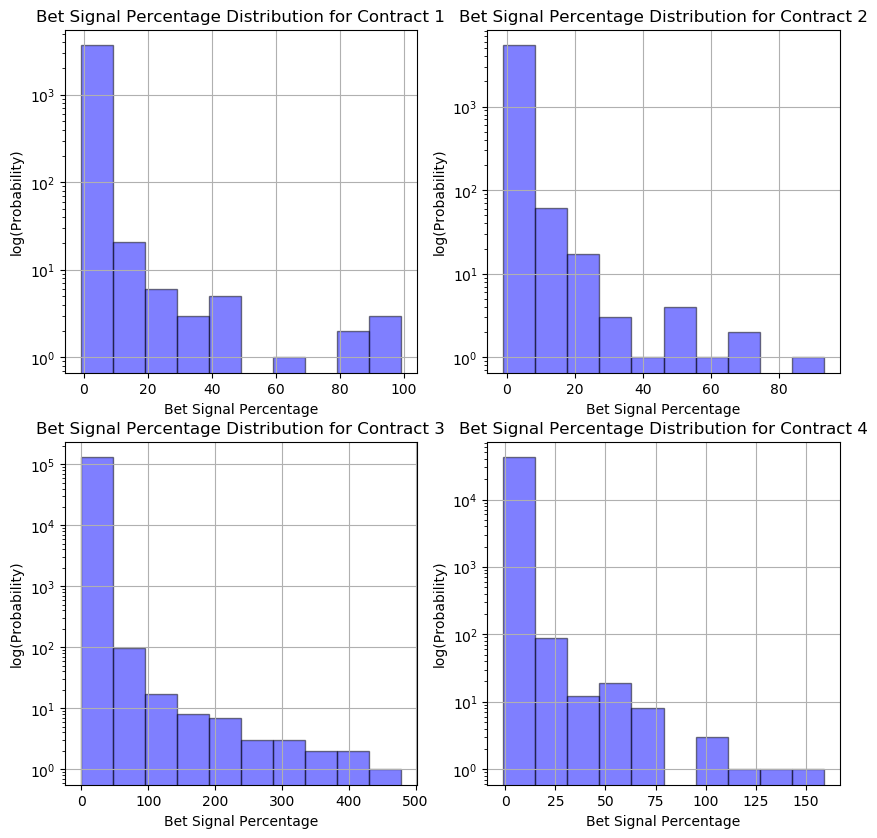

In [33]:
post_etl = signal_analysis(all_user_data)
get_distribution(post_etl, 'Bet Signal Percentage', False)


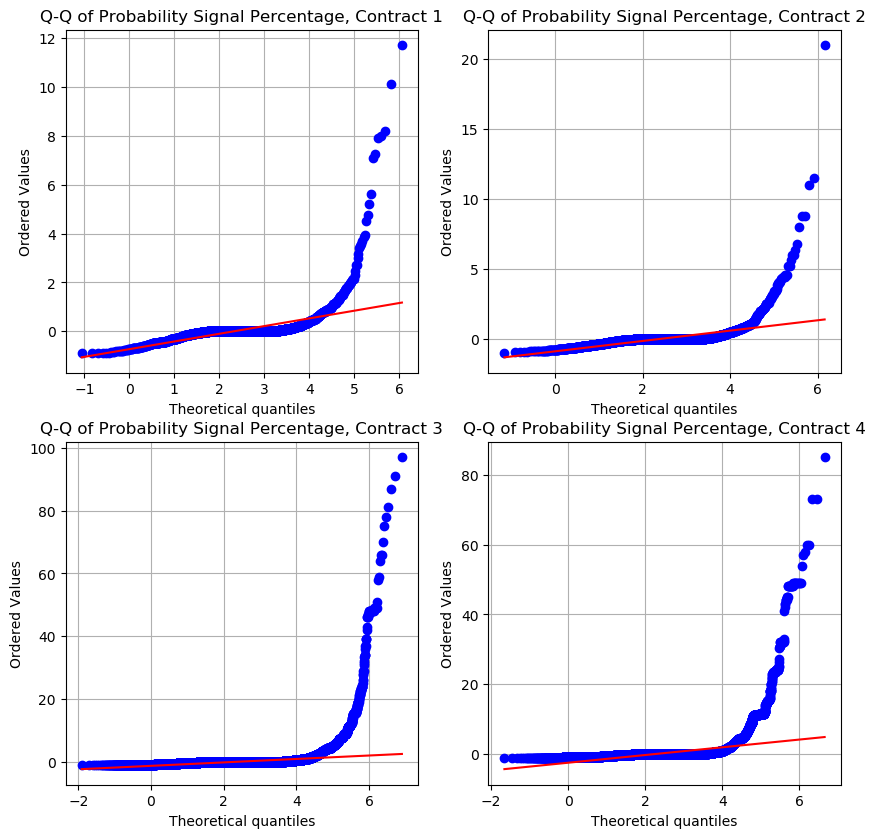

In [13]:
plot_QQ(post_etl, 'Probability Signal Percentage', False)


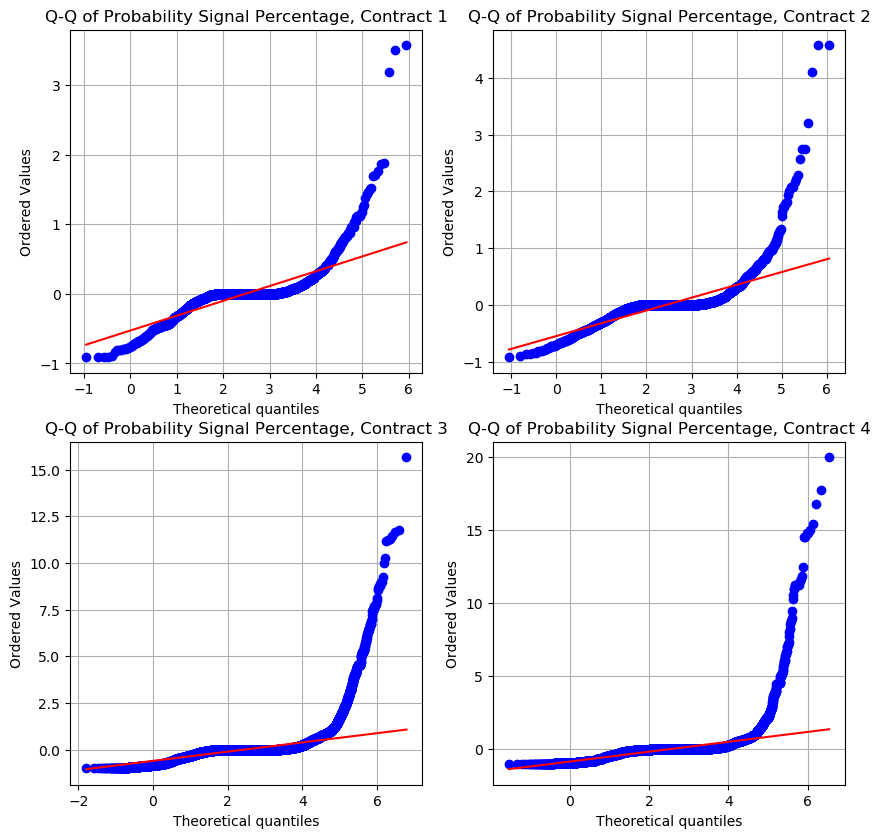

In [58]:
plot_QQ(post_etl[post_etl['Result'] == 'won'], 'Probability Signal Percentage', False)


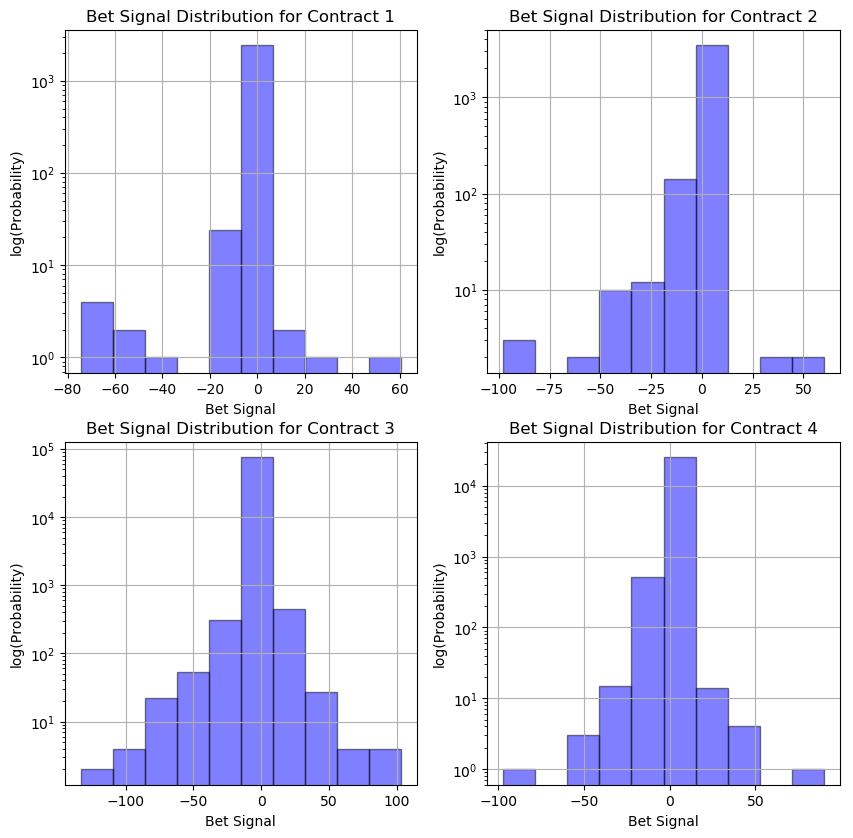

In [57]:
get_distribution(post_etl[post_etl['Result'] == 'won'], 'Bet Signal')


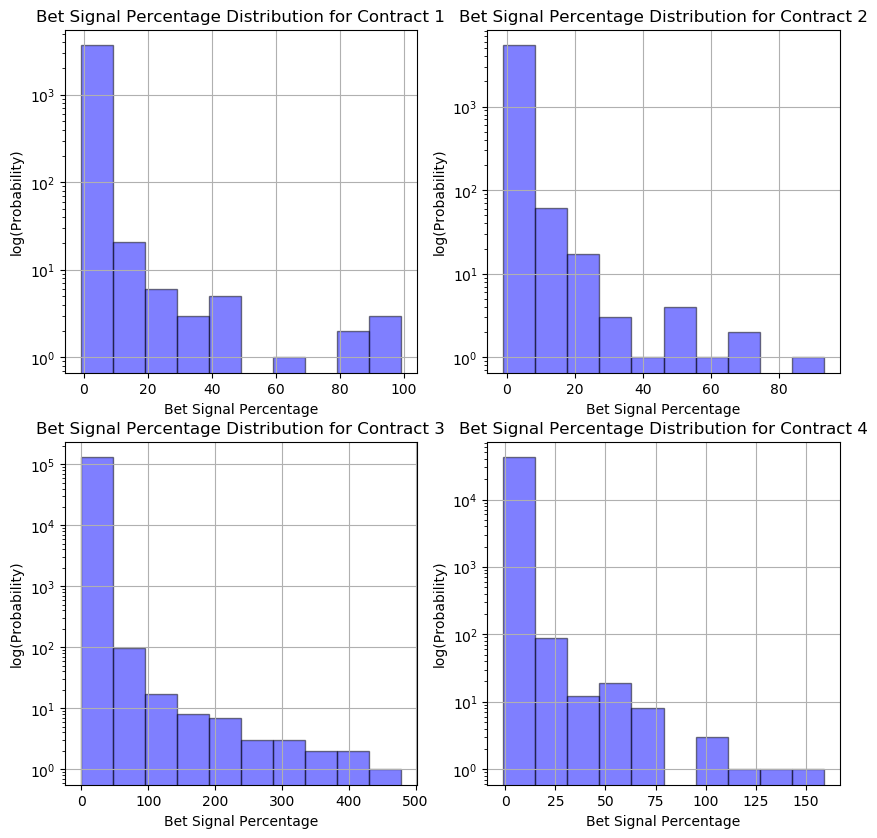

In [15]:
get_distribution(post_etl, 'Bet Signal Percentage')


In [16]:
post_etl['Bet Signal Percentage'].max()

477.99999999999994